# Image Classification Project

## Import

In [ ]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor,Compose,RandomHorizontalFlip, Normalize, ToPILImage, RandomRotation, ColorJitter
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision
import torch.optim.lr_scheduler as lr_scheduler

from dataset import StoneDataset
from tools.plot import show_images, plot_metrics

In [ ]:
seed = 1
random.seed(seed)  # Python 内置随机数种子
np.random.seed(seed)  # NumPy 随机种子
torch.manual_seed(seed)  # PyTorch 随机种子
torch.cuda.manual_seed(seed)  # 设置 CUDA 的随机种子
torch.cuda.manual_seed_all(seed)  # 如果有多个 GPU 也要设置
torch.backends.cudnn.deterministic = True  # 让 CNN 结果可复现
torch.backends.cudnn.benchmark = False  # 关闭自动优化

# dataset config
batch_size = 256

# transform config
# √：Normalize参数由数据集计算得出实际数值
# TODO: 修改训练集各变换参数,
# TODO: 视ViT本身性质
# TODO: 训练集数据扩充, 改善数据不平衡情况 (optional)
transform_train = transforms.Compose(
    [
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),  # 50% 概率水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 颜色抖动
    transforms.RandomRotation(15),           # 旋转 ±15 度
    transforms.ToTensor(),
    transforms.Normalize((0.46020824, 0.4554496,  0.45052096), (0.28402117, 0.28318824, 0.28876383))]) 

transform_test = transforms.Compose(
    [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.46107383, 0.45589945, 0.45033285), (0.28263338, 0.28181302, 0.28723977))])

In [ ]:
# 加载数据集
dataset_train = StoneDataset(root="./dataset/train_val", split="train", transforms=transform_train)
dataset_val = StoneDataset(root="./dataset/train_val", split="val", transforms=transform_test)
dataset_test = StoneDataset(root="./dataset/test", split="test", transforms=transform_test)   # for Kaggle test only

print(f"Train size: {len(dataset_train)}")
print(f"Val size: {len(dataset_val)}")
print(f"Test size: {len(dataset_test)}")

# 测试加载
img, label = dataset_train[0]
print(f"Sample image shape: {img.shape}, Label: {label}")

In [ ]:
trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Implement ViT

In [3]:
#TODO: 在该文档或者其他.py文件实现ViT模型
model = #ViT()
print(model) # 打印网络结构
x = #torch.randn(1, 3, 224, 224)
print(model(x).shape) # 测试网络输出

LeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
torch.Size([1, 10])


## Training Loop

In [4]:
# 训练一个batch的函数
def train_one_batch(model, inputs, labels, optimizer, criterion, device):

    inputs, labels = inputs.to(device), labels.to(device)
    
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    loss.backward()
    optimizer.step()
    
    return loss, outputs

# Evaluation

In [5]:
# 测试函数
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


## Main Loop

In [6]:
# 超参数
num_epochs = 60

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet().to(device)


criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


# 记录训练过程中的指标
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
learning_rates = []

# 训练循环
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_correct = 0
    total_samples = 0
    
    # 按batch训练
    for i, batch_data in enumerate(trainloader):
        inputs, labels = batch_data
        inputs, labels = inputs.to(device), labels.to(device)
        batch_loss, batch_output = train_one_batch(model, inputs, labels, optimizer, criterion, device)
        epoch_loss += batch_loss.item()
        
        _, batch_prediction = torch.max(batch_output.data, 1)
        batch_size = labels.size(0)
        total_samples += batch_size
        epoch_correct += (batch_prediction == labels).sum().item()
            
    avg_train_loss = epoch_loss / len(trainloader)
    avg_train_acc = epoch_correct / total_samples
    
    # 测试
    val_loss, val_acc = evaluate(model, testloader, criterion, device)
    
    # 记录指标
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    learning_rates.append(scheduler.get_last_lr()[0])  # 记录当前学习率

    scheduler.step()
    
    # 打印训练状态
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    print(f'Current Learning Rate: {scheduler.get_last_lr()[0]:.6f}')  # 打印当前学习率

Epoch [1/60]
Train Loss: 2.0365, Train Acc: 0.2299
Test Loss: 1.9047, Test Acc: 0.3000
Current Learning Rate: 0.009993
Epoch [2/60]
Train Loss: 1.7702, Train Acc: 0.3541
Test Loss: 1.6933, Test Acc: 0.3931
Current Learning Rate: 0.009973
Epoch [3/60]
Train Loss: 1.5650, Train Acc: 0.4364
Test Loss: 1.4415, Test Acc: 0.4745
Current Learning Rate: 0.009938
Epoch [4/60]
Train Loss: 1.4744, Train Acc: 0.4684
Test Loss: 1.4025, Test Acc: 0.4887
Current Learning Rate: 0.009891
Epoch [5/60]
Train Loss: 1.4221, Train Acc: 0.4869
Test Loss: 1.3467, Test Acc: 0.5146
Current Learning Rate: 0.009830
Epoch [6/60]
Train Loss: 1.3785, Train Acc: 0.5052
Test Loss: 1.3273, Test Acc: 0.5237
Current Learning Rate: 0.009755
Epoch [7/60]
Train Loss: 1.3375, Train Acc: 0.5202
Test Loss: 1.2935, Test Acc: 0.5346
Current Learning Rate: 0.009668
Epoch [8/60]
Train Loss: 1.3125, Train Acc: 0.5298
Test Loss: 1.2732, Test Acc: 0.5413
Current Learning Rate: 0.009568
Epoch [9/60]
Train Loss: 1.2771, Train Acc: 0.54

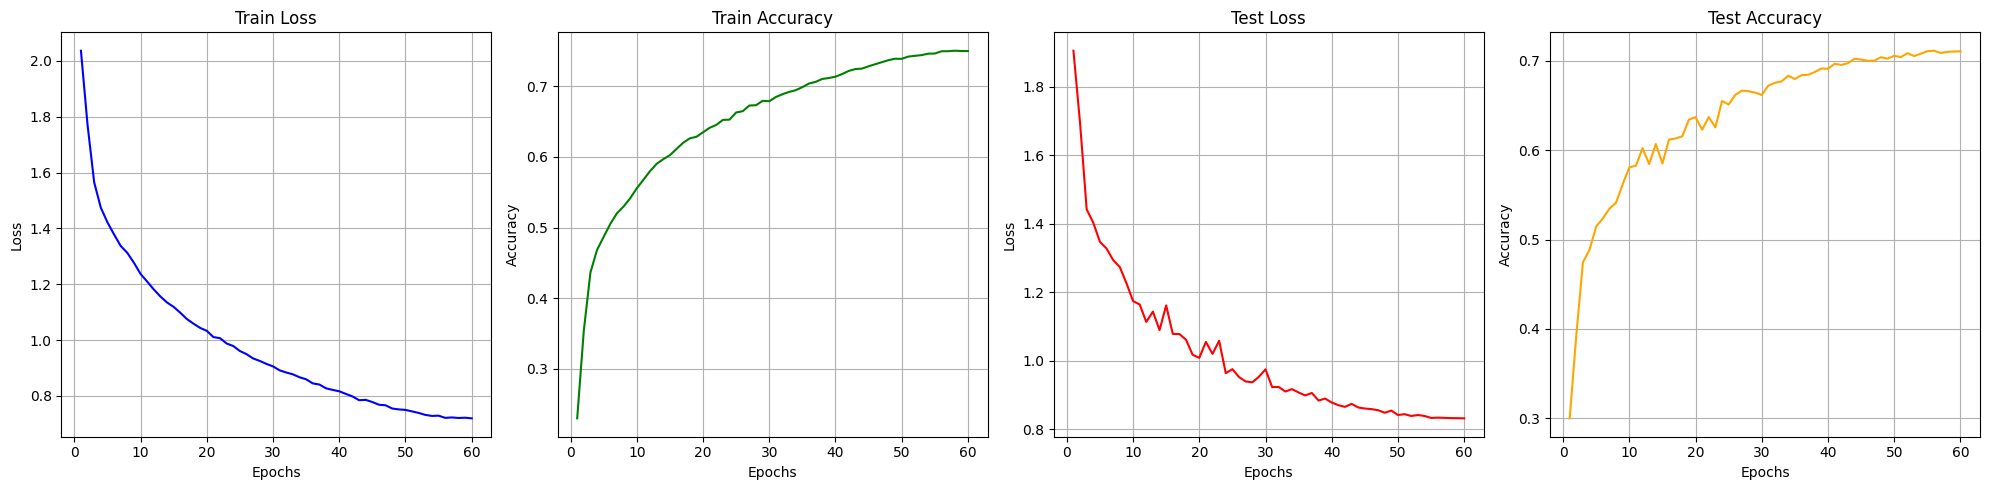

In [7]:
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies)